In [92]:
import numpy as np
import pandas as pd
from functools import partial

In [9]:
from folktables import ACSDataSource, ACSEmployment, ACSPublicCoverage
data_source = ACSDataSource(survey_year=2018, horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=['NY'], download=True)
X, y, group = ACSPublicCoverage.df_to_numpy(acs_data)

columns = [
            'AGEP',
            'SCHL',
            'MAR',
            'SEX',
            'DIS',
            'ESP',
            'CIT',
            'MIG',
            'MIL',
            'ANC',
            'NATIVITY',
            'DEAR',
            'DEYE',
            'DREM',
            'PINCP',
            'ESR',
            'ST',
            'FER',
            'RAC1P',
        ]
X = pd.DataFrame(X, columns=columns)

In [149]:
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegression
from sklearn.metrics import log_loss

def LinReg(X, y, wts):
    reg = LinearRegression()
    reg.fit(X, y, sample_weight=wts)
    return reg

def SGD(X, y, wts):
    reg = SGDClassifier(alpha=0.01, max_iter=200)
    reg.fit(X, y, sample_weight=wts)
    return reg

def LogReg(X, y, wts):
    reg = LogisticRegression()
    reg.fit(X, y, sample_weight=wts)
    return reg

def filter_grp(x, y, g_):
    return x[g_], y[g_]

def eps_k(h, L, x_k, y_k, round=False):
    return L(y_k, h.predict(x_k) if not round else h.predict_(x_k).round())

def eps_k_rand(H, L, x_k, y_k, round=False):
    N = len(y_k)
    models = [choice(H) for _ in range(N)]
    preds = [
        (
            models[i].predict(x_k[i].reshape(1, -1))
            if not round
            else models[i].predict(x_k[i].reshape(1, -1)).round()
        ).item()
        for i in range(N)
    ]
    return L(y_k, preds)

def weights_updater(lr, err, old_wts, g_):
    old_wts[g_] = old_wts[g_] * np.exp(lr * err)
    return old_wts

In [11]:
X_ = X.to_numpy()

In [150]:

# Number of iterations
T = 300
L = log_loss
k = 3
G = [None for _ in range(k)]


G[0] = np.where(X['RAC1P'] == 6)
G[1] = np.where(X['RAC1P'] == 2)
G[2] = np.where(X['NATIVITY'] == 2)


def MinimaxFair(X, y, G, L, T, H_, lr=None):
    H = [None for _ in range(T)]
    N = len(y)
    K = len(G)
    lr = lr if lr else np.log(N) / T
    weights = np.ones(N) / N
    overall_errs = []

    for t in range(T):
        h_t = H_(X, y, weights)
        H[t] = h_t
        errs = [None for _ in range(K)]
        for k in range(K):
            err = eps_k(h_t, sklearn.metrics.zero_one_loss, *filter_grp(X, y, G[k]))
            weights = weights_updater(lr, err, weights, G[k])
            errs[k] = err
        overall_errs.append(errs)
        if t % 10 == 0:
            print(f"Iteration {t}")
    return H, overall_errs

In [98]:
# Diff model classes and loss functions --
# Plotting --
# Hyperparam tuning --
# Group finder

In [120]:
import sklearn
from random import choice


H_bar, errs_1 = MinimaxFair(X_, y, G, L, T, SGD)

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240
Iteration 250
Iteration 260
Iteration 270
Iteration 280
Iteration 290


In [116]:
H_bar_2, errs_2 = MinimaxFair(X_, y, G, L, T, LinReg)

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240
Iteration 250
Iteration 260
Iteration 270
Iteration 280
Iteration 290


In [97]:
def test(H, X, y, G, L, eps):
    K = len(G)
    errs = [None for _ in range(K)]
    for k in range(K):
        err = eps(H, L, *filter_grp(X, y, G[k]))
        errs[k] = err
    return errs

errors = test(H_bar_2, X_, y, G, sklearn.metrics.mean_squared_error, partial(eps_k_rand, round=False))

print(errors)

L_2 = sklearn.metrics.mean_squared_error

print(min(L_2(y, m.predict(X_)) for m in H_bar_2))

[0.22819032512890533, 0.22347936950079997, 0.22967528275871518]
0.20460702204395503


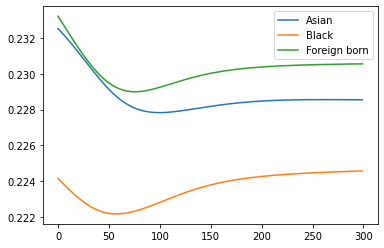

In [117]:
import matplotlib.pyplot as plt
plt.plot(np.array(errs_2))
plt.legend(["Asian", "Black", "Foreign born"])

In [151]:
import warnings
warnings.filterwarnings("ignore")
H_bar_3, errs_3 = MinimaxFair(X_, y, G, L, T, LogReg)

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240
Iteration 250
Iteration 260
Iteration 270
Iteration 280
Iteration 290


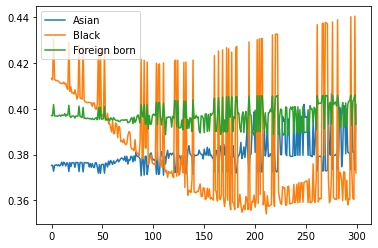

In [152]:
plt.plot(np.array(errs_3))
plt.legend(["Asian", "Black", "Foreign born"])

In [156]:
test(H_bar_3, X_, y, G, sklearn.metrics.zero_one_loss, partial(eps_k_rand, round=False))

[0.38110749185667747, 0.38362527823478176, 0.3971684520453549]